##KNN Classifier on Iris Dataset
In this implementation two **Sepal length** and **Sepal width** features of Iris dataset are used for classification. Since they have a higher correlation with output label.
The input feature matrix has the form of $X \in \mathbb{R}^{N \times D}$ and the output vector $y \in \{1,\ldots,C\}^N$ where N is number of samples and D is number of features (here D = 2). The data is then randomly splitted to create the train and test sets.


In [11]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Set the random seed
np.random.seed(124)

Number of Classes:  3 
Number of Samples:  150 
Num of Features:  2


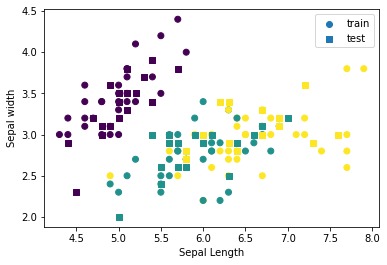

In [17]:
#Importing  Iris Dataset

#to read more about load_iris() function refer to: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html

from sklearn import datasets
iris = datasets.load_iris()
#print(iris.DESCR)
#help(iris) 

#Reading features and labels

x = iris['data'][:,:2]
y = iris['target']

(N, D), C = x.shape, np.max(y)+1

inds = np.random.permutation(N) 

X_train, y_train = x[inds[:100]], y[inds[:100]]
X_test, y_test = x[inds[100:]], y[inds[100:]]

print(f'Number of Classes: ', C, '\nNumber of Samples: ' , N, '\nNum of Features: ', D)


#plt.figure(figsize=(8,6))
plt.scatter(X_train[:,0], X_train[:,1], c = y_train, marker='o', label='train')
plt.scatter(X_test[:,0], X_test[:,1], c = y_test, marker = 's', label = 'test')

plt.xlabel('Sepal Length')
plt.ylabel('Sepal width')
plt.legend()
plt.show()

In [13]:
#KNN

#Distance measures
euclidean  = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis = -1))
manhattan = lambda x1, x2: np.sum(np.absolute(x1 - x2), axis = -1) 


def KNN(x_train, x_test, y_train, distfunc, K):
  ''' KNN Algorithm: Finding K nearest neighbors '''
  num_test = x_test.shape[0]
  distance = np.zeros((num_test, x_train.shape[0]))
  Knns = np.zeros((num_test, K))
  y_prob = np.zeros((num_test, C))

  # Adds a dimension to x_test and x_train to find all the distances between train and test samples

  distance = distfunc(x_test[:, None, :], x_train[None, :, :]) #(Result: num_test x num_train)
  Knns = np.argsort(distance, axis=1)[:,:K]

  for i in range(num_test): 
     
    y_prob[i] = np.bincount(y_train[Knns[i,:]], minlength = C)
  y_prob = y_prob/K

  return y_prob, Knns

K = 5
y_prob, Knns = KNN(X_train, X_test, y_train, euclidean, K) 

y_pred = np.argmax(y_prob, axis=1)
accuracy = sum(y_test==y_pred)/ X_test.shape[0]

print('Accuracy is ', accuracy*100)

Accuracy is  76.0


 ## Plotting results

 In this section we plot results of KNN classification.

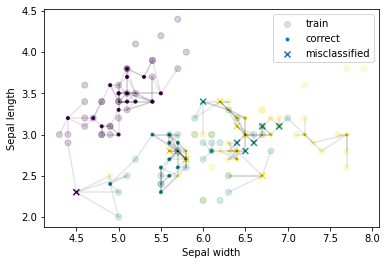

In [14]:
correct = y_pred == y_test
incorrect = np.logical_not(correct) 


plt.scatter(X_train[:,0], X_train[:,1], c= y_train, alpha=0.2, marker = 'o', label = 'train')
plt.scatter(X_test[correct,0], X_test[correct, 1], c = y_test[correct], marker = '.', label = 'correct')
plt.scatter(X_test[incorrect,0], X_test[incorrect, 1], c = y_test[incorrect], marker = 'x', label = 'misclassified')

#Connecting each node to its K nearest neighbors

for i in range(X_test.shape[0]):
  for k in range(K): 
    a = X_test[i,0], X_train[Knns[i,k],0]
    b = X_test[i,1], X_train[Knns[i,k],1] 
    plt.plot(a, b, 'k-', alpha=.1)


plt.legend()
plt.xlabel('Sepal width')
plt.ylabel('Sepal length')
plt.show()


##Decision Boundries
Linearly spaced test samples are created in the range of features.

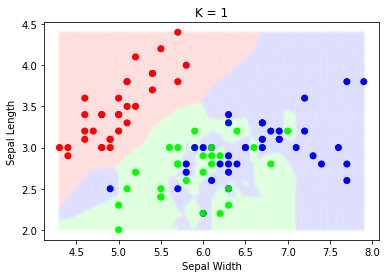

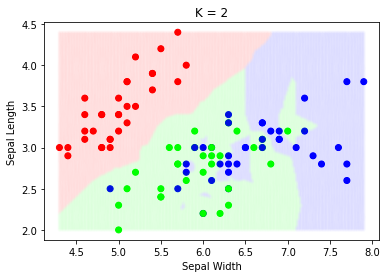

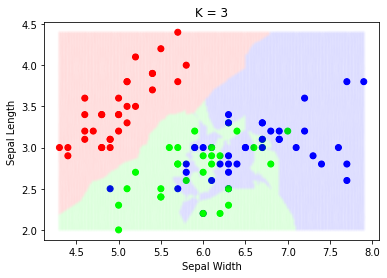

In [15]:
#New test points in the range of features
x1 = np.linspace(np.min(x[:,0]), np.max(x[:,0]), num=200)
x2 = np.linspace(np.min(x[:,1]), np.max(x[:,1]), num=200)

#Creating the grid
x0, x1 = np.meshgrid(x1, x2)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

#Defining labels of train and test

for K in range(1,4):
  y_prob_train = np.zeros((y_train.shape[0], C))
  y_prob_train[np.arange(y_train.shape[0]), y_train] = 1

  #y_prob_train is a num_samples x C matrix, one for the class with highest probability in train data
  #y_pred_all is a num_samples x C matrix, one for the class with highest probability in test data

  y_pred_all = np.zeros((x_all.shape[0], C))
  y_prob_all, Knns = KNN(X_train, x_all, y_train, euclidean, K) 
  y_pred_all[np.arange(x_all.shape[0]), np.argmax(y_prob_all, axis=-1)] = 1

  ##Plot

  plt.scatter(X_train[:,0], X_train[:,1], c= y_prob_train, marker = 'o') 
  plt.scatter(x_all[:,0], x_all[:,1], c = y_pred_all, marker = '.', alpha=0.01)
  plt.xlabel('Sepal Width')
  plt.ylabel('Sepal Length')
  plt.title('K = %i' %K)
  plt.show()


##The Effect of Noise and Feature Scaling
In this section a noise with different scales is added as a feature and the results are shown in a log-spaced plot. As expected the plot is showing decrease in accuracy as noise level increases.

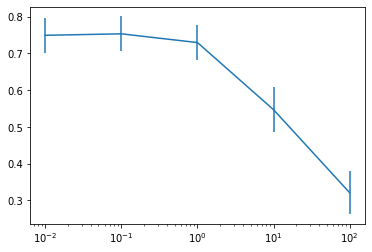

In [16]:
#Different noise Scales

noise_scale = [0.01, 0.1, 1, 10, 100]
random_noise = np.random.randn(x.shape[0],1)
results = []

for s in noise_scale:
  #adding a noise column as feature
  x_n = np.column_stack((x, random_noise*s)) 
  results.append([]) 

  for r in range(100):
    inds = np.random.permutation(N)

    x_train, y_train = x_n[inds[:100],:], y[inds[:100]]
    x_test, y_test = x_n[inds[100:],:], y[inds[100:]] 

    y_prob, Knns = KNN(x_train, x_test, y_train, euclidean, K) 

    y_pred = np.argmax(y_prob, axis=1) 
    accuracy = sum(y_test==y_pred)/ y_test.shape[0]
    results[-1].append(accuracy)


results = np.array(results)
#Taking mean and standard of 100 experiments

plt.errorbar(noise_scale, results.mean(1), results.std(1))
plt.xscale('log')